# Template fitting for richness-mass binned by cosi
## Zhuowen Zhang
### First Created April 16, 2018
#### Updated Aug 22, 2018
#### Nov. 16: Changed file reading for halo run catalog. read_shape_param is more flexible. 

In [1]:
import numpy as np

# import pyplot and set some parameters to make plots prettier
import matplotlib.pyplot as plt
from tools.plot_utils import plot_pretty
plot_pretty()
%matplotlib inline

import sys
sys.path.append('/home/zzbenjamin94/Desktop/Astronomy/Research/DES_Galaxy_Cluster')
from mpl_toolkits.mplot3d import Axes3D
from tools.setup.setup import tools_home_dir, home_dir
import astropy.io.fits as fits
shapedir = home_dir()+'output/buzzard/halo_shape/'
tpltdir = home_dir() + 'output/lmda_cosi_chains/hrun/'
buzzdir = home_dir() + 'output/buzzard/'
toolsdir = tools_home_dir()
homedir = home_dir()

import astropy.io.fits as pyfits
import ConfigParser
import healpy as hp
import treecorr
import os

from repo.halo_shape.halo_shape_stats_backend import kmeans_stats, student_t_test
from repo.halo_shape.read_shape_param import halo_bin_stat, read_shape_param

### Import halo files, apply cuts, and extract parameters

In [2]:
from repo.halo_shape.read_shape_param import read_shape_param
import numpy.lib.recfunctions as rfn

filename = 'halo_shape_hruncut_allz.npy'
halo_shape = np.load(shapedir+filename)
num_bcut = len(halo_shape)

#Apply convergence cut
conv_cut = np.where(halo_shape['converge']==True)
halo_shape = halo_shape[conv_cut]
print "After convergence cut ", len(halo_shape), " out of initial ", num_bcut, " remain." 

#Find corresponding richness and mass of halos_ID in hrun, after shape cut
filename = homedir + 'data/halo_run/buzzard-0_1.6_y3_run_halos_lambda_chisq_chto_fullhalo_final_chto.fit'
hrun_list = fits.open(filename)
hrun_data = hrun_list[1].data

#First do a lambda cut
lmda_cut = np.where((hrun_data['LAMBDA_CHISQ'] >= 5.))
hrun_data = hrun_data[lmda_cut]
print "lmda for hrun completed: ", len(hrun_data), " halos remain"

#Cut for hrun_data
shapecut = [ind for (ind, val) in enumerate(hrun_data['HALOID']) if val in halo_shape['halos_ID']]
hrun_data = hrun_data[shapecut]
print "shapecut for hrun completed: ", len(hrun_data), " halos remain"

#Cut for halo_shape
ID_cut = [ind for (ind, val) in enumerate(halo_shape['halos_ID']) if val in hrun_data['HALOID']]
halo_shape = halo_shape[ID_cut]
print "ID_cut for halo_shape completed: ", len(halo_shape), " halos remain"

assert len(halo_shape) == len(hrun_data), 'hrun_data and halo_shape don\'t have equal number of halos'

After convergence cut  133637  out of initial  134908  remain.
lmda for hrun completed:  129978  halos remain
shapecut for hrun completed:  119708  halos remain
ID_cut for halo_shape completed:  119708  halos remain


In [3]:
##Shorthand name for relevant halo/redM parameters
richness= hrun_data.LAMBDA_CHISQ
halos_M = hrun_data.M200B
halos_ID_shapecut, q, s, cos_i =  read_shape_param(halo_shape, convcut=True)

### Binning Halos Files -- by cos(i) and richness

In [4]:
from repo.halo_shape.read_shape_param import halo_bin_stat

#Bin by cosine
cosi_num_bin = 5
cosi_bin_edge = np.linspace(0,1,cosi_num_bin+1)
cosi_bins = []
for i in range(cosi_num_bin):
    cosi_bins.append([cosi_bin_edge[i], cosi_bin_edge[i+1]])
    
cosi_bins_ind = halo_bin_stat(cos_i, cosi_bins)
    
#Bin by richness
lmda_max = np.max(richness)
lmda_bins = [[20,30],[30,50],[50,lmda_max]] #upper limit must match lower limit of next bin
num_lmda_bins = len(lmda_bins)
lmda_bins_ind = halo_bin_stat(richness, lmda_bins)
print 'Maximum richness after cuts is ', lmda_max

#Contains all halos. List should be of length with an array that contains all halos.
all_ind = [np.arange(len(q))]

Maximum richness after cuts is  494.7688


In [5]:
#Binning richness by cos_i
num_bins = len(cosi_bins)
lnM200b_binned = [None]*num_bins
lnl_binned = [None]*num_bins

lnl = np.log(richness)
lnM200b = np.log(halos_M)

for i, cosi_bin in enumerate(cosi_bins):
    lnM200b_binned[i] = np.log(halos_M[cosi_bins_ind[i]])
    lnl_binned[i] = np.log(richness[cosi_bins_ind[i]])

## Generating fake data

### Testing with Fake Data

#### Test with Model 1

The posteriors found through sampling the fake data is in the ballpark and has good contours but is off in absolute value. 

| Parameter   |   True   | Found   |
|-------------|----------|---------|
|  As         |   20.08  |   5.74  |   
|  Bs         |   0.5    |  0.677  | 
|  sig0s      |   0.5    |  0.628  | 

This is before I matched the hmf of fake data with that used in model. Model2 results are after adjustment and they match well. 

#### Test with Model 2
The posteriors found through sampling the fake data is in the ballpark and has good contours but is off in absolute value. 

| Parameter   |   True   | Found                  |
|-------------|----------|---------               |
|  $A_0$         |   22.19  |   22.77 $\pm$ 0.39   |   
|  $A_1$         |   24.53  |   24.21 $\pm$ 0.40   |   
|  $A_2$         |   27.11  |   27.59 $\pm$ 0.42  |   
|  $A_3$         |   29.96  |   30.21 $\pm$ 0.43  |   
|  $A_4$         |   33.11  |   32.59 $\pm$ 0.44  |   
|  Bs         |   0.6    |  0.59 $\pm$ 0.01       | 
|  sig0s      |   0.3    |  0.30 $\pm$ 0.01       | 

Results agree. 

#### Test with model 3
This model varies A only, and inputs the best fit B and sig0 found from the maximum posterior from model2. 
Unlike model2, this model input does not allow input of lnl and lnM from different bins. To find posterior for different
bins need to call the model each time, creating a MCMC folder for each bin. 


| Parameter   |   True   | Found                  |
|-------------|----------|---------               |
|  $A$         |   20.09  |   20.08 $\pm$ 0.37   |   

Results agree. 

## Template for richness-mass

Assume a linear relation in richness-mass in the log-log plane, and with a log-normal scatter. Free parameters are A the intercept, B the slope, and sig0 the instrinsic scatter.

The truncated Gaussian at $\lambda = 20$ is normalized with the mass function from the random halo catalog in the Buzzard simulations. 

The linear relation between richness and mass is
$$
\mu_{\log(\lambda)} = \log{A} + B*(\log{M} - \log{10^{14}})
$$

with instrinsic scatter
$$
\sigma^2(\log{\lambda}) = \sigma_0^2 + \frac{\exp{\mu}-1}{2\exp{\mu}}.
$$

The posterior probability is 
$$
P(A,B,\sigma|\lambda, M) = \frac{1}{N(A,B,\sigma, M)}P(\lambda, M | A, B, \sigma) P (A, B, \sigma),
$$

with normalization factor
$$
N(A, B, \sigma, M) = \int dM \int_{20}^{+\infty} d \lambda P(\lambda| M, A, B, \sigma) P(M)
= \int dM(0.5 - 0.5 \mathrm{erf}\big(\frac{\mathrm{ln} 20 - \mu{(\mathrm{ln} \lambda)}}{\sqrt{2(\sigma_0^2+ \frac{\mathrm{exp} ( \mu{(\mathrm{ln} \lambda)})-1}{\mathrm{exp} ( 2\mu{(\mathrm{ln} \lambda)})})}} \big) P(M).
$$

$P(M)$ is sampled from the randomly selected halo (see code tools.halo_mass_template) and integration is done by tabulating P(M) into 100 bins. 

**See lmda_cosi_model.py for explanation of different models**



### Generating MCMC Chains with real data

In [6]:
from repo.richness_mass.lmda_cosi_model import make_model, make_model2, make_model3 #this takes a while because of tab hmf
from pymc import *
from pymc import DiscreteUniform, Normal, uniform_like, TruncatedNormal
from pymc import Metropolis
from numpy.random import randn
import matplotlib.pyplot as plt
from scipy.special import erf
from chainconsumer import ChainConsumer

shapecut for hrun completed in halo_mass_template


#### For model1

In [ ]:
#MCMC chain setup
num=100
n_iter=num*3000
n_burn=num*500
n_thin=num    

#data input

mcmc_filestr = range(len(cosi_bins))
#For binned by cos_i
for i in mcmc_filestr:
    print '\n Bin number ', i
    mcmc_folder = tpltdir  + 'p_lmda_cosi_'+str(mcmc_filestr[i])+'_model1'
    cosi_bin_ind = cosi_bins_ind[i]
    M=pymc.Model(make_model(lnl_binned[i], lnM200b_binned[i]))
    mc=MCMC(M, db='txt', dbname=mcmc_folder)
    mc.sample(iter=n_iter, burn=n_burn, thin=n_thin)

#### For model2

In [ ]:
#This is the data input format for model2
#MCMC chain setup
num=100
n_iter=num*3000
n_burn=num*500
n_thin=num     

#For different bins. Vary A but keep B and sigma fixed. 
mcmc_folder = tpltdir  + 'p_lmda_cosi_' +'all_'+'model2'
M=pymc.Model(make_model2(lnl_binned, lnM200b_binned)) #Use make_model2 for binned data. 
mc=MCMC(M, db='txt', dbname=mcmc_folder)
mc.sample(iter=n_iter, burn=n_burn, thin=n_thin)

#### For model3

In [7]:
mcmc_folder = tpltdir + 'p_lmda_cosi_'+'all'+'_model2'

#Need to input the global B, sigma0 found from model2. Model 3 only makes sense after running and inputting the posterior
#from model2
c = ChainConsumer() 
for i in range(1):
    cosi_bin_min = cosi_bins[i][0]; cosi_bin_max = cosi_bins[i][1]
    As=np.genfromtxt(mcmc_folder+'/Chain_0/A_{}.txt'.format(i))
    Bs=np.genfromtxt(mcmc_folder+'/Chain_0/B.txt')
    sig0s=np.genfromtxt(mcmc_folder+'/Chain_0/sigma0.txt')

    # plot the parameter constraints
    data=np.vstack( (As, Bs, sig0s) ).T
    c.add_chain(data, parameters=[r"$A$", r"$B$", r"$\sigma_0$"], \
                name=r'Template for $cos(i)\in[%.1f, %.1f)$'%(cosi_bin_min, cosi_bin_max))

    c.configure(statistics="max_shortest")

c_posterior = c.analysis.get_summary()    
B_post_model2 = c_posterior["$B$"][1] #Find max likelihood value
sig0_post_model2 = c_posterior["$\sigma_0$"][1] #Find max likelihood value
    
B_allfit =  B_post_model2           #hrun B_max: 0.761646
sigma0_allfit = sig0_post_model2    #hrun sigma0_max: 0.582257
print B_allfit, sigma0_allfit

num=100
n_iter=num*3000
n_burn=num*500
n_thin=num   

0.7616460160427363 0.5822568954754924


In [8]:
#For different cosine bins
mcmc_filestr=range(cosi_num_bin)
for i in mcmc_filestr:
    print '\n Bin number ', i
    mcmc_folder = tpltdir  + 'p_lmda_cosi_'+str(mcmc_filestr[i])+'_model3'
    cosi_bin_ind = cosi_bins_ind[i]
    M=pymc.Model(make_model3(lnl_binned[i], lnM200b_binned[i], B_allfit, sigma0_allfit))
    mc=MCMC(M, db='txt', dbname=mcmc_folder)
    mc.sample(iter=n_iter, burn=n_burn, thin=n_thin)


 Bin number  0
 [-----------------100%-----------------] 300000 of 300000 complete in 536.9 sec
 Bin number  1
 [-----------------100%-----------------] 300000 of 300000 complete in 544.3 sec
 Bin number  2
 [-----------------100%-----------------] 300000 of 300000 complete in 538.8 sec
 Bin number  3
 [-----------------100%-----------------] 300000 of 300000 complete in 547.8 sec
 Bin number  4
 [-----------------100%-----------------] 300000 of 300000 complete in 546.0 sec

In [10]:
#Combined for model3
mcmc_folder = tpltdir + 'p_lmda_cosi_'+'all_'+'model3'
M=pymc.Model(make_model3(lnl, lnM200b, B_allfit, sigma0_allfit))
mc=MCMC(M, db='txt', dbname=mcmc_folder)
mc.sample(iter=n_iter, burn=n_burn, thin=n_thin)

 [-----------------100%-----------------] 300000 of 300000 complete in 2530.1 sec

## Posterior distribution

In [36]:
from scipy.stats import sem
c = ChainConsumer() #contains multiple chains across different models

#### For model1

In [37]:
for i in range(len(cosi_bins)):

    cosi_bin_min = cosi_bins[i][0]; cosi_bin_max = cosi_bins[i][1]
    mcmc_folder = tpltdir + 'p_lmda_cosi_'+str(i)+'_model1'
        
    As=np.genfromtxt(mcmc_folder+'/Chain_0/A.txt')
    Bs=np.genfromtxt(mcmc_folder+'/Chain_0/B.txt')
    sig0s=np.genfromtxt(mcmc_folder+'/Chain_0/sigma0.txt')

    # plot the parameter constraints
    data=np.vstack( (As, Bs, sig0s) ).T
    c.add_chain(data, parameters=[r"$A$", r"$B$", r"$\sigma_0$"], \
                name=r'Model1 for $cos(i)\in[%.1f, %.1f)$'%(cosi_bin_min, cosi_bin_max))
    c.configure(statistics="max_shortest")

#### For model2

In [39]:
mcmc_folder = tpltdir + 'p_lmda_cosi_'+'all'+'_model2'

#for i in range(len(cosi_bins)):
    #cosi_bin_min = cosi_bins[i][0]; cosi_bin_max = cosi_bins[i][1]
    #As=np.genfromtxt(mcmc_folder+'/Chain_0/A_{}.txt'.format(i))
    
Bs=np.genfromtxt(mcmc_folder+'/Chain_0/B.txt')
sig0s=np.genfromtxt(mcmc_folder+'/Chain_0/sigma0.txt')

    # plot the parameter constraints
data=np.vstack( (Bs, sig0s) ).T
c.add_chain(data, parameters=[r"$B$", r"$\sigma_0$"], \
                name=r'Template for $cos(i)\in[%.1f, %.1f)$'%(cosi_bin_min, cosi_bin_max))
c.configure(statistics="max_shortest")

#### For model3

In [40]:
for i in range(len(cosi_bins)):
    mcmc_folder = tpltdir + 'p_lmda_cosi_'+str(i)+'_model3'
    As = np.genfromtxt(mcmc_folder+'/Chain_0/A.txt')
    data = As
    c.add_chain(data, parameters=[r"$A$"], name=r'Template for $cos(i)\in[%.1f, %.1f)$'%(cosi_bin_min, cosi_bin_max))
    c.configure(statistics="max_shortest")
    
#Combined
mcmc_folder = tpltdir + 'p_lmda_cosi_'+'all'+'_model3'
As = np.genfromtxt(mcmc_folder+'/Chain_0/A.txt')
data = As
c.add_chain(data, parameters=[r"$A$"], name=r'Model3 for $cos(i)\in[%.1f, %.1f)$'%(cosi_bin_min, cosi_bin_max))
c.configure(statistics="max_shortest")
#c.plot(filename="test1.png", figsize="column", truth=[A, B, sig0])

## Processing the posterior likelihood statistics

The Chainconsumer object c contains multiple chains read from the section "Generating MCMC chain from data posteriors"

Chains 0-4 are the cosine bins in model1. 

Chain 5 are the fit from model2. The sigma and B parameters should be the same across these chains. 

Chains 6-10 are the cosine fit from model3 -- this is one where vary A only and take best fit B,sigma from model2. 

Chain 11 is the combined fit for model3



### A makeshift script for testing model. Need to systematize

In [29]:
#Plotting posterior for B
c_posterior = c.analysis.get_summary()
#print c_posterior

lnA_post_model2 = np.zeros((5,3)) #Universal fit
B_post_model2 = np.zeros((1,3)) #Univesal fit across cosine bins
sig0_post_model2 = np.zeros((1,3))

for i in range(6):
    #lnA_post_model2[i] = np.log(c_posterior[i]["$A$"])
    #print "B ", c_posterior[i]["$B$"]
    print "A ",  c_posterior[i]["$A$"]
    #print "sig0 ", c_posterior[i]["$\sigma_0$"]
    print '\n'
    
#B_post_model2 = c_posterior[0]["$B$"]
#sig0_post_model2 = c_posterior[0]["$\sigma_0$"]

print B_post_model2[1]

 A  [17.5193851768429, 17.578408789359177, 17.672448645336235]


A  [17.92728563184171, 18.02959387479394, 18.08887501041578]


A  [18.37340111334196, 18.46662082206148, 18.53480520883382]


A  [19.743035537974258, 19.836295910678864, 19.91765854860706]


A  [22.443634808386307, 22.501973864684683, 22.63554033986059]


A  [19.198694385139117, 19.22322975479013, 19.272998967340637]




IndexError: index 1 is out of bounds for axis 0 with size 1

/home/zzbenjamin94/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


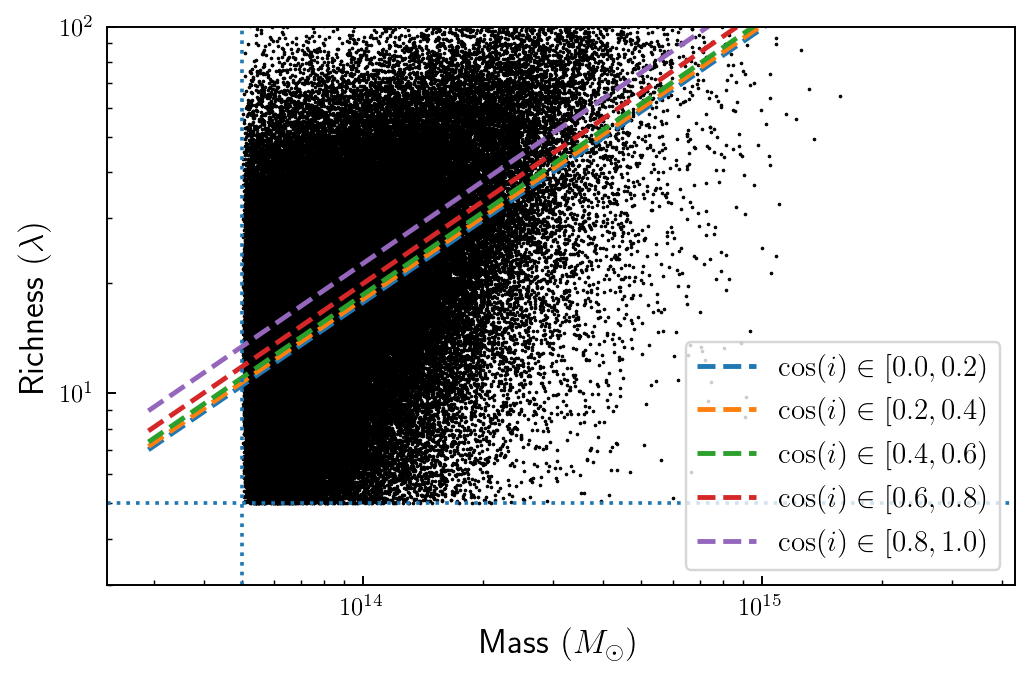

In [16]:
#Plot the trendlines for different bins
fig, axs = plt.subplots(1 ,1, tight_layout=True, figsize=(6,4))
axs.plot(halos_M, richness, 'k.', markersize=1)

lnM_range = np.arange(31,35,0.1)
B_cosi_maxL = B_post_model2[1]; sig0_cosi_maxL = sig0_post_model2[1]
for i, cosi_bin in enumerate(cosi_bins):
    cosi_bin_min = cosi_bin[0]; cosi_bin_max = cosi_bin[1]
    lnA_cosi_maxL = lnA_post_model2[i,1]; 
    mu_lnl_model = lnA_cosi_maxL + B_cosi_maxL*(lnM_range-np.log(10)*14)
    sig_lnl_model=np.sqrt(sig0_cosi_maxL**2+(np.exp(mu_lnl_model)-1)/(np.exp(2*mu_lnl_model)))
    axs.plot(10**(lnM_range/np.log(10)), np.exp(mu_lnl_model), linewidth=2, linestyle='dashed', \
        label='$\cos(i) \in [{:.1f}, {:.1f})$'.format(cosi_bin_min,cosi_bin_max))

axs.axhline(5, linestyle='dotted')
axs.axvline(5e13, linestyle='dotted')
axs.set_yscale('log')
axs.set_xscale('log')
axs.legend(fontsize=12)
axs.set_xlabel('Mass $(M_\odot)$',fontsize=14)
axs.set_ylabel('Richness $(\lambda)$',fontsize=14)
axs.set_ylim((3,100))
#axs.axvspan(2.05e14, 2.13e14, alpha=0.5)
#axs.axhline(40)
#plt.savefig('mass_richness_cosibinned_60718.png')
plt.show()

[17.5193851768429, 17.578408789359177, 17.672448645336235]
[17.92728563184171, 18.02959387479394, 18.08887501041578]
[18.37340111334196, 18.46662082206148, 18.53480520883382]
[19.743035537974258, 19.836295910678864, 19.91765854860706]
[22.443634808386307, 22.501973864684683, 22.63554033986059]
[19.198694385139117, 19.22322975479013, 19.272998967340637]


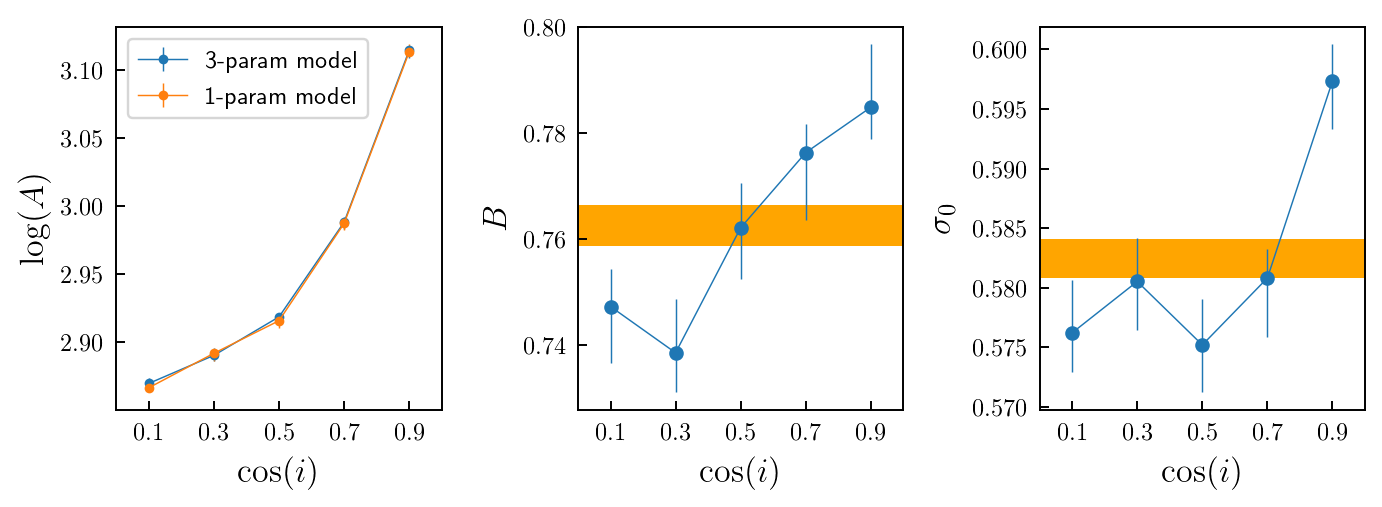

In [41]:
#Posterior. For each paramater array contains 3 indexes -- low, max posterior, and high range. 
'''
funk = c_posterior[i]["$A$"] reads the A parameter statistic of the i-th chain. 
The statistic is read as array of min, mean, max values of statistic (e.g. max_shhortest),
so that funk[1], for instance,  is the mean value of A in the ith chain. 
'''

c_posterior = c.analysis.get_summary()

#x parameters are the mean of each cosi_bin
x_pos = np.zeros(len(cosi_bins))
for i, cosi_bin in enumerate(cosi_bins):
    cosi_bin_min = cosi_bin[0]; cosi_bin_max = cosi_bin[1]
    x_pos[i] = (cosi_bin_max+cosi_bin_min)/2.
#print x_pos

#Posterior likelihoods
lnA_post_model1 = np.zeros((len(cosi_bins),3))
B_post_model1 = np.zeros((len(cosi_bins),3))
sig0_post_model1 = np.zeros((len(cosi_bins),3))

B_post_model2 = np.zeros((1,3)) #Universal fit
sig0_post_model2 = np.zeros((1,3)) #Univesal fit across cosine bins

lnA_post_model3 = np.zeros((len(cosi_bins)+1,3)) #A plus the combined fit


#For model1
for i in range(0,5):
    lnA_post_model1[i] = np.log(c_posterior[i]["$A$"])
    B_post_model1[i] = c_posterior[i]["$B$"]
    sig0_post_model1[i] = c_posterior[i]["$\sigma_0$"]
    
#B, sigma0 for model2
for i in range(5,6):
    B_post_model2[i-5] = c_posterior[i]["$B$"]
    sig0_post_model2[i-5] = c_posterior[i]["$\sigma_0$"]
    
#A for model3
for i in range(6,12):
    lnA_post_model3[i-6] = np.log(c_posterior[i]["$A$"])
    print c_posterior[i]["$A$"]
    

#Plotting the posteriors #########################################################
#Plotting posterior for lnA
fig, axs = plt.subplots(1, 3, tight_layout=True, figsize=(8,3))
subtitles = [r'$\log(A)$', r'$B$', r'$\sigma_0$']
stat_name = ["$A$", "$B$", "$\sigma_0$"]

axs[0].errorbar(x_pos, lnA_post_model1[:,1], \
                yerr=[lnA_post_model1[:,1]-lnA_post_model1[:,0], lnA_post_model1[:,2]-lnA_post_model1[:,1]], \
                linewidth=0.6, marker='o',markersize=3, label='3-param model')

axs[0].errorbar(x_pos, lnA_post_model3[:-1,1], \
                yerr=[lnA_post_model3[:-1,1]-lnA_post_model3[:-1,0], lnA_post_model3[:-1,2]-lnA_post_model3[:-1,1]], \
                linewidth=0.6, marker='o', markersize=3, label='1-param model')    

#Plotting posterior for B

axs[1].errorbar(x_pos, B_post_model1[:,1], \
                yerr=[B_post_model1[:,1]-B_post_model1[:,0], B_post_model1[:,2]-B_post_model1[:,1]], \
                linewidth=0.6, marker='o',markersize=5, label='3-param model')

xband = np.linspace(0,1,5)
axs[1].fill_between(xband, B_post_model2[:,0], B_post_model2[:,2], \
                facecolor='orange', interpolate=False, label='1-param model')  

#Plotting posterior for sigma0
axs[2].errorbar(x_pos, sig0_post_model1[:,1], \
                yerr=[sig0_post_model1[:,1]-sig0_post_model1[:,0], sig0_post_model1[:,2]-sig0_post_model1[:,1]], \
                linewidth=0.6, marker='o',markersize=5, label='3-param model')

axs[2].fill_between(xband, sig0_post_model2[:,0], sig0_post_model2[:,2], \
                facecolor='orange', interpolate=False, label='1-param model')  

for i in range(3):
    axs[i].set_xlim((0,1))
    axs[i].set_xticks(x_pos)
    axs[i].set_ylabel(subtitles[i], size=14)
    axs[i].set_xlabel(r'$\cos(i)$', size=14) 

axs[2].set_xlabel(r'$\cos(i)$', size=14) 
axs[0].legend(fontsize=10)
#plt.savefig('richness_mass_modelparams_cosibinned_060718.png')
plt.show()

(4, 800)

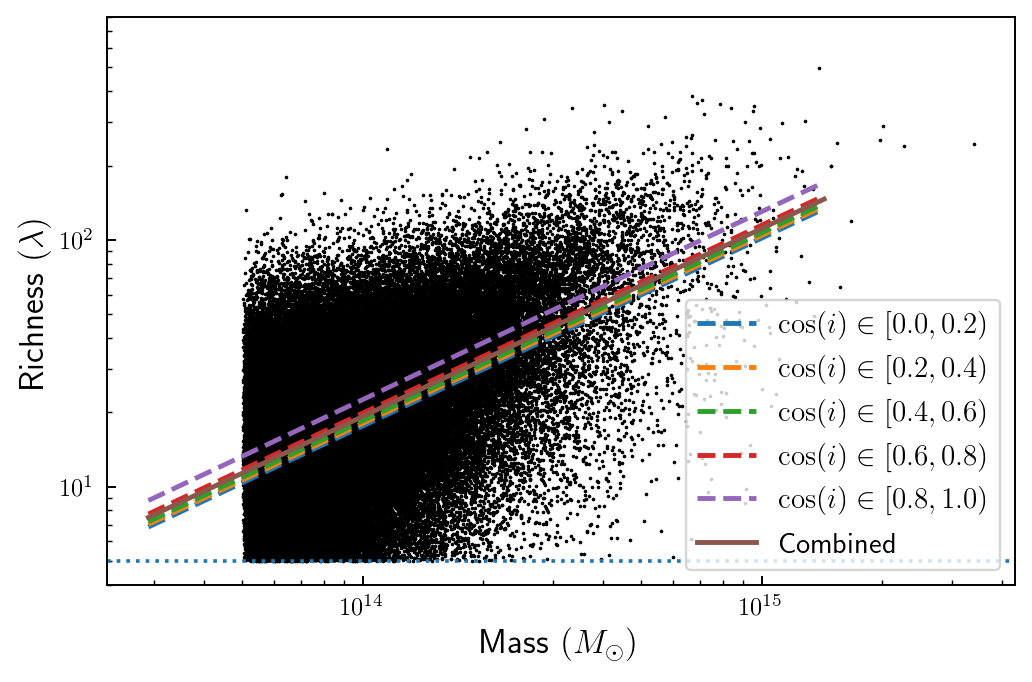

In [47]:
#Plot the trendlines for different bins
fig, axs = plt.subplots(1 ,1, tight_layout=True, figsize=(6,4))
axs.plot(halos_M, richness, 'k.', markersize=1)

lnM_range = np.arange(31,35,0.1)
B_cosi_maxL = B_post_model2[0,1]; sig0_cosi_maxL = sig0_post_model2[0,1]
for i, cosi_bin in enumerate(cosi_bins):
    cosi_bin_min = cosi_bin[0]; cosi_bin_max = cosi_bin[1]
    lnA_cosi_maxL = lnA_post_model3[i,1]; 
    mu_lnl_model = lnA_cosi_maxL + B_cosi_maxL*(lnM_range-np.log(10)*14)
    sig_lnl_model=np.sqrt(sig0_cosi_maxL**2+(np.exp(mu_lnl_model)-1)/(np.exp(2*mu_lnl_model)))
    axs.plot(10**(lnM_range/np.log(10)), np.exp(mu_lnl_model), linewidth=2, linestyle='dashed', \
        label='$\cos(i) \in [{:.1f}, {:.1f})$'.format(cosi_bin_min,cosi_bin_max))
             
#for all data points    
lnA_cosi_maxL = lnA_post_model3[-1,1]; B_cosi_maxL = B_post_model2[0,1]; sig0_cosi_maxL = sig0_post_model2[0,1]
mu_lnl_model = lnA_cosi_maxL + B_cosi_maxL*(lnM_range-np.log(10)*14)
sig_lnl_model=np.sqrt(sig0_cosi_maxL**2+(np.exp(mu_lnl_model)-1)/(np.exp(2*mu_lnl_model)))
axs.plot(10**(lnM_range/np.log(10)), np.exp(mu_lnl_model), \
            label='Combined', linewidth=2)
axs.axhline(5, linestyle='dotted')
axs.set_yscale('log')
axs.set_xscale('log')
axs.legend(fontsize=12)
axs.set_xlabel('Mass $(M_\odot)$',fontsize=14)
axs.set_ylabel('Richness $(\lambda)$',fontsize=14)
axs.set_ylim((4,800))
#axs.axvspan(2.05e14, 2.13e14, alpha=0.5)
#axs.axhline(40)
#plt.savefig('mass_richness_cosibinned_60718.png')
#plt.show()

### Generating BIC for different models

In [48]:
'''
Calculates the BIC for a given model.
D: mean log(x|theta) across posterior distribution theta.
k: number of free parameters
N: number of data points
'''

def calc_bic(D,k,N):
    return -2*D + k*np.log(N)

In [49]:
for i in range(len(cosi_bins)):
    #For model 3
    mcmc_folder = tpltdir + 'p_lmda_cosi_'+str(i)+'_model3'       
    deviance = np.genfromtxt(mcmc_folder+'/Chain_0/deviance.txt')
    bic_model3 = calc_bic(np.mean(deviance), 1, len(richness[cosi_bins_ind[i]]))
    print "BIC in cosi bin ", i, "for model 3 is ", bic_model3
    
    #For model 1
    mcmc_folder = tpltdir + 'p_lmda_cosi_'+str(i)+'_model1'       
    As=np.genfromtxt(mcmc_folder+'/Chain_0/A.txt')
    deviance = np.genfromtxt(mcmc_folder+'/Chain_0/deviance.txt')
    bic_model3 = calc_bic(np.mean(deviance), 3, len(richness[cosi_bins_ind[i]]))
    print "BIC in cosi bin ", i, "for model 1 is ", bic_model3


BIC in cosi bin  0 for model 3 is  8802.249810595345
BIC in cosi bin  0 for model 1 is  8826.637488274153
BIC in cosi bin  1 for model 3 is  8066.8255471673365
BIC in cosi bin  1 for model 1 is  8095.357290602198
BIC in cosi bin  2 for model 3 is  8106.821737336745
BIC in cosi bin  2 for model 1 is  8130.42170082569
BIC in cosi bin  3 for model 3 is  6465.8633935723665
BIC in cosi bin  3 for model 1 is  6486.503462408631
BIC in cosi bin  4 for model 3 is  2590.342361076275
BIC in cosi bin  4 for model 1 is  2654.174595430184
